In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
gdp = pd.read_csv('data/gdp_quarterly.csv')
hh_debt = pd.read_csv('data/household_debt_to_net_disposable_income_yearly.csv')
unrate = pd.read_csv('data/unemployment_rate_monthly.csv')
housing = pd.read_csv('data/housing_prices_quarterly.csv')
govt = pd.read_csv('data/govt_spending_to_gdp_yearly.csv')
inflation = pd.read_csv('data/cpi_monthly.csv')
ppi = pd.read_csv('data/ppi_monthly.csv')

Always keep in mind that the data obtained is in different periods. In order to compare and interpret the effect of each of the features, we need to make adjustment to the timing. Here, we compute each of their percentage change over the previous year.

### Real quarterly GDP, percentage change over year
The value represents quarterly GDP change over previous year.

In [3]:
gdp.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,OECD,QGDP,TOT,PC_CHGPP,A,1962,5.698613,NaN
1,OECD,QGDP,TOT,PC_CHGPP,A,1963,5.200709,NaN
2,OECD,QGDP,TOT,PC_CHGPP,A,1964,6.376178,NaN
3,OECD,QGDP,TOT,PC_CHGPP,A,1965,5.352665,NaN
4,OECD,QGDP,TOT,PC_CHGPP,A,1966,5.754541,NaN


In [4]:
gdp.nunique()

LOCATION         54
INDICATOR         1
SUBJECT           2
MEASURE           3
FREQUENCY         2
TIME            371
Value         23075
Flag Codes        3
dtype: int64

In [5]:
print(gdp['SUBJECT'].unique(), gdp['MEASURE'].unique(), gdp['FREQUENCY'].unique())

['TOT' 'VOLIDX'] ['PC_CHGPP' 'PC_CHGPY' 'IDX'] ['A' 'Q']


In [6]:
# percentage change from previous year
gdp = gdp[(gdp['SUBJECT'] == 'TOT') & (gdp['MEASURE'] == 'PC_CHGPY') & (gdp['FREQUENCY'] == 'Q')]

In [7]:
gdp['TIME'] = pd.to_datetime(gdp['TIME']).dt.to_period('Q').dt.end_time
print(gdp['TIME'])

84      1961-03-31 23:59:59.999999999
85      1961-06-30 23:59:59.999999999
86      1961-09-30 23:59:59.999999999
87      1961-12-31 23:59:59.999999999
88      1962-03-31 23:59:59.999999999
                     ...             
29910   2019-12-31 23:59:59.999999999
29911   2020-03-31 23:59:59.999999999
29912   2020-06-30 23:59:59.999999999
29913   2020-09-30 23:59:59.999999999
29914   2020-12-31 23:59:59.999999999
Name: TIME, Length: 9331, dtype: datetime64[ns]


In [8]:
gdp_new = gdp.loc[:, ['LOCATION', 'TIME', 'Value']].copy()
gdp_new.columns = ['Location', 'Time', 'GDP_growth']
gdp_new.head()

,Location,Time,GDP_growth
84,DEU,1961-03-31 23:59:59.999999999,7.450290
85,DEU,1961-06-30 23:59:59.999999999,5.002099
86,DEU,1961-09-30 23:59:59.999999999,3.576950
87,DEU,1961-12-31 23:59:59.999999999,2.996161
88,DEU,1962-03-31 23:59:59.999999999,3.466854


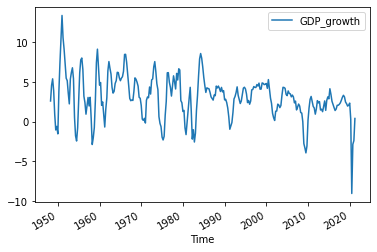

In [9]:
gdp_new[gdp_new['Location'] == 'USA'].plot(x='Time', y='GDP_growth')

### Household debt, % of net disposable income
The value represents the debt to income ratio at the end of the year. We will upsample the data into quarterly, then interpolate and difference it to the percentage change of its previous year's value once the Location is selected in the EDA step.

In [10]:
hh_debt.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,HHDEBT,TOT,PC_NDI,A,1995,94.86145,NaN
1,AUS,HHDEBT,TOT,PC_NDI,A,1996,98.62147,NaN
2,AUS,HHDEBT,TOT,PC_NDI,A,1997,106.62240,NaN
3,AUS,HHDEBT,TOT,PC_NDI,A,1998,114.09520,NaN
4,AUS,HHDEBT,TOT,PC_NDI,A,1999,120.42900,NaN


In [11]:
hh_debt.nunique()

LOCATION       36
INDICATOR       1
SUBJECT         1
MEASURE         1
FREQUENCY       1
TIME           26
Value         797
Flag Codes      0
dtype: int64

In [12]:
hh_debt['LOCATION'].unique()

array(['AUS', 'AUT', 'BEL', 'CZE', 'DNK', 'FIN', 'FRA', 'DEU', 'GRC',
       'HUN', 'IRL', 'ITA', 'JPN', 'KOR', 'LUX', 'MEX', 'NLD', 'NOR',
       'POL', 'PRT', 'SVK', 'ESP', 'SWE', 'CHE', 'GBR', 'USA', 'CHL',
       'EST', 'SVN', 'CAN', 'LVA', 'BRA', 'LTU', 'RUS', 'NZL', 'COL'],
      dtype=object)

In [13]:
hh_debt['TIME'].unique()

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020])

In [14]:
hh_debt['TIME'] = pd.to_datetime(hh_debt['TIME'].astype(str), format='%Y').dt.to_period('A').dt.end_time
hh_debt['TIME']

0     1995-12-31 23:59:59.999999999
1     1996-12-31 23:59:59.999999999
2     1997-12-31 23:59:59.999999999
3     1998-12-31 23:59:59.999999999
4     1999-12-31 23:59:59.999999999
                   ...             
792   2015-12-31 23:59:59.999999999
793   2016-12-31 23:59:59.999999999
794   2017-12-31 23:59:59.999999999
795   2018-12-31 23:59:59.999999999
796   2019-12-31 23:59:59.999999999
Name: TIME, Length: 797, dtype: datetime64[ns]

In [15]:
hh_debt_new = hh_debt.loc[:, ['LOCATION', 'TIME', 'Value']].copy()
hh_debt_new.columns = ['Location', 'Time', 'HH_debt_income']
hh_debt_new.head()

,Location,Time,HH_debt_income
0,AUS,1995-12-31 23:59:59.999999999,94.86145
1,AUS,1996-12-31 23:59:59.999999999,98.62147
2,AUS,1997-12-31 23:59:59.999999999,106.62240
3,AUS,1998-12-31 23:59:59.999999999,114.09520
4,AUS,1999-12-31 23:59:59.999999999,120.42900


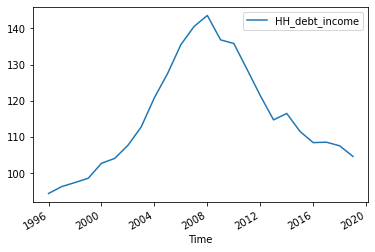

In [16]:
hh_debt_new[hh_debt_new['Location'] == 'USA'].plot(x='Time', y='HH_debt_income')

### Unemployment rate, % of labour force
The value represents the unemployment rate at the end of the reported period. There are 3 reporting periods: monthly, quarterly, and annual. We only need to compute its percentage change from the previous year.

In [17]:
unrate.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,HUR,TOT,PC_LF,A,1967,1.875,NaN
1,AUS,HUR,TOT,PC_LF,A,1968,1.850,NaN
2,AUS,HUR,TOT,PC_LF,A,1969,1.800,NaN
3,AUS,HUR,TOT,PC_LF,A,1970,1.625,NaN
4,AUS,HUR,TOT,PC_LF,A,1971,1.925,NaN


In [18]:
unrate.nunique()

LOCATION         42
INDICATOR         1
SUBJECT           3
MEASURE           1
FREQUENCY         3
TIME           1162
Value         13485
Flag Codes        3
dtype: int64

In [19]:
print(unrate['SUBJECT'].unique(), unrate['FREQUENCY'].unique(), unrate['Flag Codes'].unique())

['TOT' 'MEN' 'WOMEN'] ['A' 'Q' 'M'] [nan 'B' 'E' 'P']


In [20]:
unrate = unrate[(unrate['SUBJECT'] == 'TOT') & (unrate['FREQUENCY'] == 'M')]

In [21]:
unrate['TIME'] = pd.to_datetime(unrate['TIME'].astype(str), format='%Y-%m').dt.to_period('M').dt.end_time

In [22]:
unrate_new = unrate.loc[:, ['LOCATION', 'TIME', 'Value']].copy()
unrate_new.columns = ['Location', 'Time', 'Unemployment']
unrate_new.head()

,Location,Time,Unemployment
5989,AUS,1978-02-28 23:59:59.999999999,6.644867
5990,AUS,1978-03-31 23:59:59.999999999,6.302329
5991,AUS,1978-04-30 23:59:59.999999999,6.267148
5992,AUS,1978-05-31 23:59:59.999999999,6.209167
5993,AUS,1978-06-30 23:59:59.999999999,6.303327


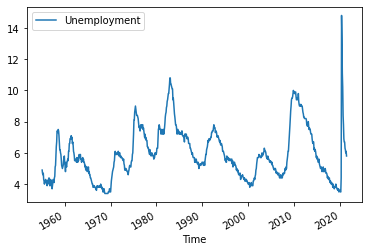

In [23]:
unrate_new[unrate_new['Location'] == 'USA'].plot(x='Time', y='Unemployment')

### Housing prices
The value represents the price and ratio at the end of the reporting periods, which are quarterly and annual. We will take the nominal (instead of real) value and ratios and compute their percentage change over their previous years.

In [24]:
housing.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,HOUSECOST,NOMINAL,IDX2015,A,1970,2.552380,NaN
1,AUS,HOUSECOST,NOMINAL,IDX2015,A,1971,2.851352,NaN
2,AUS,HOUSECOST,NOMINAL,IDX2015,A,1972,3.183667,NaN
3,AUS,HOUSECOST,NOMINAL,IDX2015,A,1973,3.837183,NaN
4,AUS,HOUSECOST,NOMINAL,IDX2015,A,1974,4.690199,NaN


In [25]:
housing.nunique()

LOCATION         50
INDICATOR         1
SUBJECT           5
MEASURE           1
FREQUENCY         2
TIME            327
Value         38323
Flag Codes        0
dtype: int64

In [26]:
print(housing['SUBJECT'].unique(), housing['FREQUENCY'].unique())

['NOMINAL' 'PRICEINCOME' 'PRICERENT' 'REAL' 'RENT'] ['A' 'Q']


In [27]:
housing_income = housing[(housing['SUBJECT'] == 'PRICEINCOME') & (housing['FREQUENCY'] == 'Q')]
housing_income['TIME'] = pd.to_datetime(housing_income['TIME']).dt.to_period('Q').dt.end_time
housing_income_new = housing_income.loc[:, ['LOCATION', 'TIME', 'Value']].copy()
housing_income_new.columns = ['Location', 'Time', 'House_price_income']

In [28]:
housing_rent = housing[(housing['SUBJECT'] == 'PRICERENT') & (housing['FREQUENCY'] == 'Q')]
housing_rent['TIME'] = pd.to_datetime(housing_rent['TIME']).dt.to_period('Q').dt.end_time
housing_rent_new = housing_rent.loc[:, ['LOCATION', 'TIME', 'Value']].copy()
housing_rent_new.columns = ['Location', 'Time', 'House_price_rent']

In [29]:
housing_new = housing_income_new.merge(housing_rent_new, on=['Location', 'Time'])
housing_new

,Location,Time,House_price_income,House_price_rent
0,AUS,1972-09-30 23:59:59.999999999,59.671086,36.266491
1,AUS,1972-12-31 23:59:59.999999999,59.944554,37.743660
2,AUS,1973-03-31 23:59:59.999999999,59.789834,37.920062
3,AUS,1973-06-30 23:59:59.999999999,61.400542,39.760156
4,AUS,1973-09-30 23:59:59.999999999,62.199570,42.423984
...,...,...,...,...
5062,COL,2018-12-31 23:59:59.999999999,104.357125,112.168525
5063,COL,2019-03-31 23:59:59.999999999,104.715704,113.743068
5064,COL,2019-06-30 23:59:59.999999999,104.180660,113.613583
5065,COL,2019-09-30 23:59:59.999999999,106.518755,116.100132


In [30]:
housing_new['Rent_income'] = housing_new['House_price_income'] / housing_new['House_price_rent']
housing_new.head()

,Location,Time,House_price_income,House_price_rent,Rent_income
0,AUS,1972-09-30 23:59:59.999999999,59.671086,36.266491,1.645350
1,AUS,1972-12-31 23:59:59.999999999,59.944554,37.743660,1.588202
2,AUS,1973-03-31 23:59:59.999999999,59.789834,37.920062,1.576734
3,AUS,1973-06-30 23:59:59.999999999,61.400542,39.760156,1.544273
4,AUS,1973-09-30 23:59:59.999999999,62.199570,42.423984,1.466142


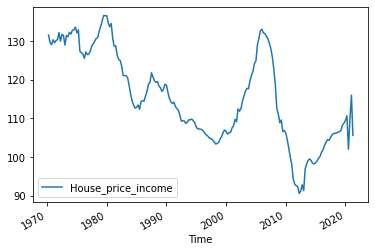

In [31]:
housing_new[housing_new['Location'] == 'USA'].plot(x='Time', y='House_price_income')

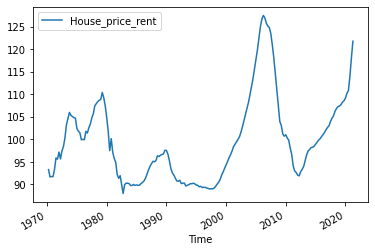

In [32]:
housing_new[housing_new['Location'] == 'USA'].plot(x='Time', y='House_price_rent')

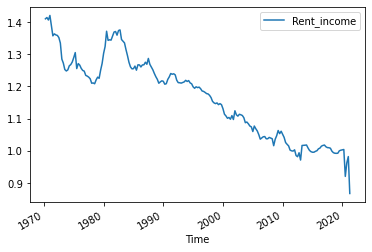

In [33]:
housing_new[housing_new['Location'] == 'USA'].plot(x='Time', y='Rent_income')

### Govt deficit, % of GDP
The value represents government deficit to GDP at the end of the year. We will upsample it to quarterly and compute its percentage change over previous year once the Location is selected in the EDA step.

In [34]:
govt.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,GGEXP,TOT,THND_USD_CAP,A,2007,13728.47,NaN
1,AUS,GGEXP,TOT,THND_USD_CAP,A,2008,14829.21,NaN
2,AUS,GGEXP,TOT,THND_USD_CAP,A,2009,15967.08,NaN
3,AUS,GGEXP,TOT,THND_USD_CAP,A,2010,15799.62,NaN
4,AUS,GGEXP,TOT,THND_USD_CAP,A,2011,16522.72,NaN


In [35]:
govt.nunique()

LOCATION        43
INDICATOR        1
SUBJECT         11
MEASURE          2
FREQUENCY        1
TIME            51
Value         9657
Flag Codes       3
dtype: int64

In [36]:
print(govt['SUBJECT'].unique(), govt['MEASURE'].unique())

['TOT' 'RECULTREL' 'HOUCOMM' 'PUBORD' 'EDU' 'ENVPROT' 'GRALPUBSER'
 'SOCPROT' 'ECOAFF' 'DEF' 'HEALTH'] ['THND_USD_CAP' 'PC_GDP']


In [37]:
govt = govt[(govt['SUBJECT'] == 'TOT') & (govt['MEASURE'] == 'PC_GDP')]

In [38]:
govt['TIME'] = pd.to_datetime(govt['TIME'].astype(str), format='%Y').dt.to_period('A').dt.end_time

In [39]:
govt_new = govt.loc[:, ['LOCATION', 'TIME', 'Value']].copy()
govt_new.columns = ['Location', 'Time', 'Spending_to_GDP']
govt_new.head()

,Location,Time,Spending_to_GDP
26,AUT,1995-12-31 23:59:59.999999999,55.806074
27,AUT,1996-12-31 23:59:59.999999999,55.624395
28,AUT,1997-12-31 23:59:59.999999999,52.272109
29,AUT,1998-12-31 23:59:59.999999999,52.224243
30,AUT,1999-12-31 23:59:59.999999999,52.061515


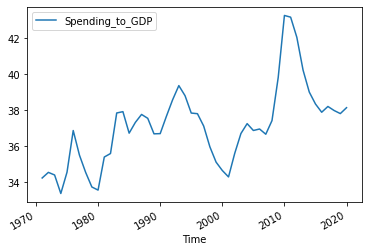

In [40]:
govt_new[govt_new['Location'] == 'USA'].plot(x='Time', y='Spending_to_GDP')

### Inflation (CPI), annual growth rate (%)
The value is already in the form of percentage change over previous year. No adjustment needed.

In [41]:
inflation.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,CPI,ENRG,AGRWTH,A,1972,4.910070,NaN
1,AUS,CPI,ENRG,AGRWTH,A,1973,3.762801,NaN
2,AUS,CPI,ENRG,AGRWTH,A,1974,13.173540,NaN
3,AUS,CPI,ENRG,AGRWTH,A,1975,19.422470,NaN
4,AUS,CPI,ENRG,AGRWTH,A,1976,8.833195,NaN


In [42]:
inflation.nunique()

LOCATION          52
INDICATOR          1
SUBJECT            4
MEASURE            2
FREQUENCY          3
TIME            1415
Value         237611
Flag Codes         1
dtype: int64

In [43]:
print(inflation['SUBJECT'].unique(), inflation['MEASURE'].unique(), inflation['FREQUENCY'].unique())

['ENRG' 'FOOD' 'TOT' 'TOT_FOODENRG'] ['AGRWTH' 'IDX2015'] ['A' 'Q' 'M']


In [44]:
inflation = inflation[(inflation['SUBJECT'] == 'TOT') & (inflation['MEASURE'] == 'IDX2015') & (inflation['FREQUENCY'] == 'Q')]
inflation.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
148062,AUS,CPI,TOT,IDX2015,Q,1948-Q3,3.436267,NaN
148063,AUS,CPI,TOT,IDX2015,Q,1948-Q4,3.529139,NaN
148064,AUS,CPI,TOT,IDX2015,Q,1949-Q1,3.622011,NaN
148065,AUS,CPI,TOT,IDX2015,Q,1949-Q2,3.714883,NaN
148066,AUS,CPI,TOT,IDX2015,Q,1949-Q3,3.807755,NaN


In [45]:
inflation['TIME'] = pd.to_datetime(inflation['TIME']).dt.to_period('Q').dt.end_time
inflation['TIME']

148062   1948-09-30 23:59:59.999999999
148063   1948-12-31 23:59:59.999999999
148064   1949-03-31 23:59:59.999999999
148065   1949-06-30 23:59:59.999999999
148066   1949-09-30 23:59:59.999999999
                      ...             
280692   2020-03-31 23:59:59.999999999
280693   2020-06-30 23:59:59.999999999
280694   2020-09-30 23:59:59.999999999
280695   2020-12-31 23:59:59.999999999
280696   2021-03-31 23:59:59.999999999
Name: TIME, Length: 10851, dtype: datetime64[ns]

In [46]:
inflation_new = inflation.loc[:, ['LOCATION', 'TIME', 'Value']].copy()
inflation_new.columns = ['Location', 'Time', 'Inflation']
inflation_new.head()

,Location,Time,Inflation
148062,AUS,1948-09-30 23:59:59.999999999,3.436267
148063,AUS,1948-12-31 23:59:59.999999999,3.529139
148064,AUS,1949-03-31 23:59:59.999999999,3.622011
148065,AUS,1949-06-30 23:59:59.999999999,3.714883
148066,AUS,1949-09-30 23:59:59.999999999,3.807755


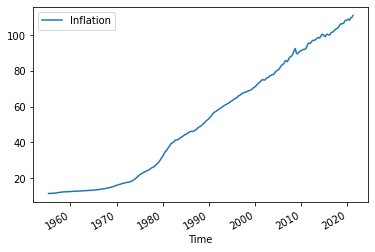

In [47]:
inflation_new[inflation_new['Location'] == 'USA'].plot(x='Time', y='Inflation')

### Producer price indice (PPI), domestic market manufacturing
Same as inflation, the value is already in the form of annual growth rate, no adjustment needed.

In [48]:
ppi.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUT,PPI,DOMESTIC,AGRWTH,A,2000,3.405336,NaN
1,AUT,PPI,DOMESTIC,AGRWTH,A,2001,0.048577,NaN
2,AUT,PPI,DOMESTIC,AGRWTH,A,2002,-1.408040,NaN
3,AUT,PPI,DOMESTIC,AGRWTH,A,2003,0.285630,NaN
4,AUT,PPI,DOMESTIC,AGRWTH,A,2004,2.219603,NaN


In [49]:
ppi.nunique()

LOCATION         45
INDICATOR         1
SUBJECT           2
MEASURE           2
FREQUENCY         3
TIME           1264
Value         59943
Flag Codes        0
dtype: int64

In [50]:
print(ppi['SUBJECT'].unique(), ppi['MEASURE'].unique(), ppi['FREQUENCY'].unique())

['DOMESTIC' 'TOT_MKT'] ['AGRWTH' 'IDX2015'] ['A' 'Q' 'M']


In [51]:
ppi['LOCATION'][ppi['SUBJECT'] == 'TOT_MKT'].unique()

array(['AUS', 'AUT', 'BEL', 'CAN', 'CZE', 'DNK', 'FIN', 'FRA', 'DEU',
       'GRC', 'HUN', 'IRL', 'ITA', 'LUX', 'NLD', 'NZL', 'NOR', 'POL',
       'PRT', 'SVK', 'ESP', 'CHE', 'GBR', 'USA', 'CHL', 'COL', 'EST',
       'LVA', 'LTU', 'SVN', 'EA19', 'SWE', 'CRI', 'EU27_2020'],
      dtype=object)

In [52]:
ppi = ppi[(ppi['SUBJECT'] == 'TOT_MKT') & (ppi['MEASURE'] == 'IDX2015') & (ppi['FREQUENCY'] == 'Q')]
ppi.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
41514,AUS,PPI,TOT_MKT,IDX2015,Q,1968-Q3,9.997597,NaN
41515,AUS,PPI,TOT_MKT,IDX2015,Q,1968-Q4,9.997597,NaN
41516,AUS,PPI,TOT_MKT,IDX2015,Q,1969-Q1,9.997597,NaN
41517,AUS,PPI,TOT_MKT,IDX2015,Q,1969-Q2,10.189860,NaN
41518,AUS,PPI,TOT_MKT,IDX2015,Q,1969-Q3,10.285990,NaN


In [53]:
ppi['TIME'] = pd.to_datetime(ppi['TIME']).dt.to_period('Q').dt.end_time
ppi.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
41514,AUS,PPI,TOT_MKT,IDX2015,Q,1968-09-30 23:59:59.999999999,9.997597,NaN
41515,AUS,PPI,TOT_MKT,IDX2015,Q,1968-12-31 23:59:59.999999999,9.997597,NaN
41516,AUS,PPI,TOT_MKT,IDX2015,Q,1969-03-31 23:59:59.999999999,9.997597,NaN
41517,AUS,PPI,TOT_MKT,IDX2015,Q,1969-06-30 23:59:59.999999999,10.189860,NaN
41518,AUS,PPI,TOT_MKT,IDX2015,Q,1969-09-30 23:59:59.999999999,10.285990,NaN


In [54]:
ppi_new = ppi.loc[:, ['LOCATION', 'TIME', 'Value']].copy()
ppi_new.columns = ['Location', 'Time', 'PPI']
ppi_new.head()

,Location,Time,PPI
41514,AUS,1968-09-30 23:59:59.999999999,9.997597
41515,AUS,1968-12-31 23:59:59.999999999,9.997597
41516,AUS,1969-03-31 23:59:59.999999999,9.997597
41517,AUS,1969-06-30 23:59:59.999999999,10.189860
41518,AUS,1969-09-30 23:59:59.999999999,10.285990


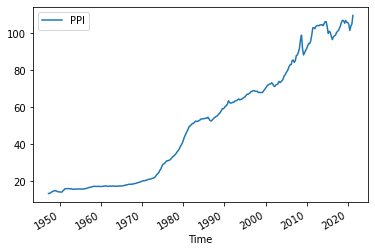

In [55]:
ppi_new[ppi_new['Location'] == 'USA'].plot(x='Time', y='PPI')

### Create new dataframe

Merge all dataframes into a final dataframe. Keep in mind that GDP is our target column, and the values exist in the feature columns but not in our target column will be useless. Hence, we use merge and left join them based on our target column.

In [56]:
df = gdp_new.merge(inflation_new, on=['Location', 'Time'], how='left')
df = df.merge(ppi_new, on=['Location', 'Time'], how='left')
df = df.merge(unrate_new, on=['Location', 'Time'], how='left')
df = df.merge(housing_new, on=['Location', 'Time'], how='left')
df = df.merge(hh_debt_new, on=['Location', 'Time'], how='left')
df = df.merge(govt_new, on=['Location', 'Time'], how='left')
df.sample(5)

,Location,Time,GDP_growth,Inflation,PPI,Unemployment,House_price_income,House_price_rent,Rent_income,HH_debt_income,Spending_to_GDP
7969,GRC,1996-03-31 23:59:59.999999999,2.632532,59.43225,61.81535,NaN,NaN,NaN,NaN,NaN,NaN
4895,DNK,1973-03-31 23:59:59.999999999,4.999813,16.03130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4346,JPN,1994-03-31 23:59:59.999999999,0.163339,97.43333,NaN,2.9,152.835000,156.772093,0.974887,NaN,NaN
2599,ZAF,1989-06-30 23:59:59.999999999,3.376637,16.81931,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6000,NOR,2016-06-30 23:59:59.999999999,0.519998,103.30000,99.14986,4.8,104.450002,103.476033,1.009413,NaN,NaN


In [57]:
df['Time'] = pd.to_datetime(df['Time']).dt.strftime('%Y-%m-%d')
df['Time'] = pd.to_datetime(df['Time'])
df.head()

,Location,Time,GDP_growth,Inflation,PPI,Unemployment,House_price_income,House_price_rent,Rent_income,HH_debt_income,Spending_to_GDP
0,DEU,1961-03-31,7.450290,23.28992,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DEU,1961-06-30,5.002099,23.46389,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DEU,1961-09-30,3.576950,23.61611,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DEU,1961-12-31,2.996161,23.70309,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DEU,1962-03-31,3.466854,24.07278,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
df.to_csv('data/step2_features_summary.csv', index=False)